Epoch [1/30], Loss: 1.0637, Accuracy: 44.94%, Learning Rate: 0.001000
Epoch [2/30], Loss: 1.0473, Accuracy: 46.77%, Learning Rate: 0.001000
Epoch [3/30], Loss: 1.0417, Accuracy: 47.01%, Learning Rate: 0.001000
Epoch [4/30], Loss: 1.0389, Accuracy: 47.87%, Learning Rate: 0.001000
Epoch [5/30], Loss: 1.0365, Accuracy: 48.48%, Learning Rate: 0.001000
Epoch [6/30], Loss: 1.0357, Accuracy: 48.56%, Learning Rate: 0.001000
Epoch [7/30], Loss: 1.0350, Accuracy: 48.80%, Learning Rate: 0.001000
Epoch [8/30], Loss: 1.0339, Accuracy: 48.64%, Learning Rate: 0.001000
Epoch [9/30], Loss: 1.0330, Accuracy: 48.92%, Learning Rate: 0.001000
Epoch [10/30], Loss: 1.0325, Accuracy: 49.09%, Learning Rate: 0.001000
Epoch [11/30], Loss: 1.0325, Accuracy: 48.96%, Learning Rate: 0.001000
Epoch [12/30], Loss: 1.0321, Accuracy: 48.84%, Learning Rate: 0.001000
Epoch [13/30], Loss: 1.0318, Accuracy: 49.21%, Learning Rate: 0.001000
Epoch [14/30], Loss: 1.0313, Accuracy: 49.00%, Learning Rate: 0.001000
Epoch [15/30], 

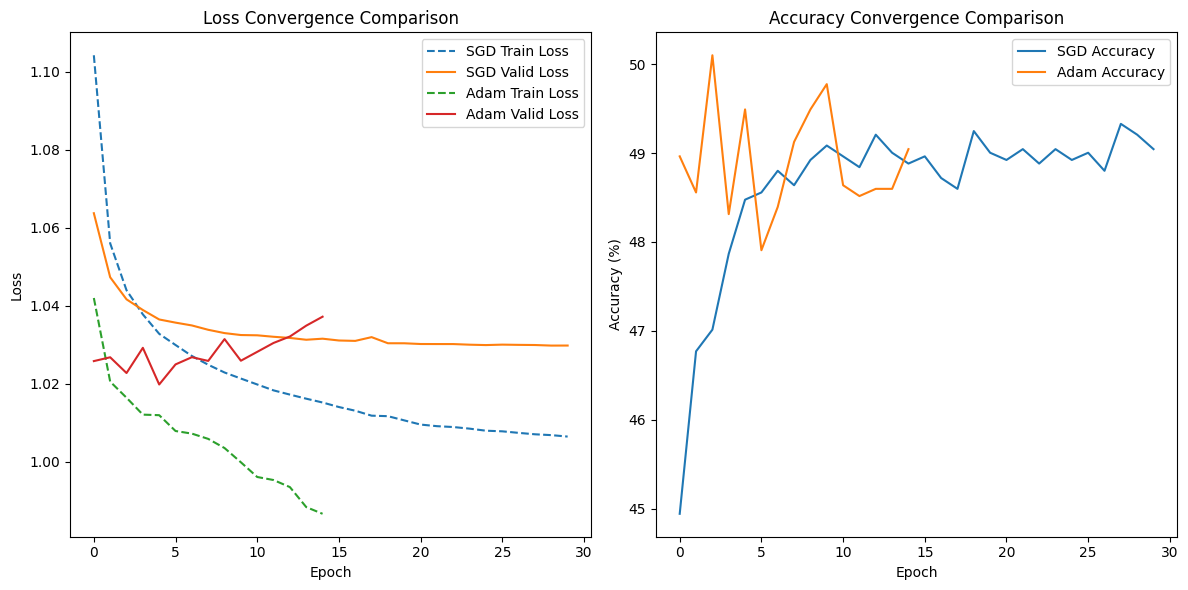

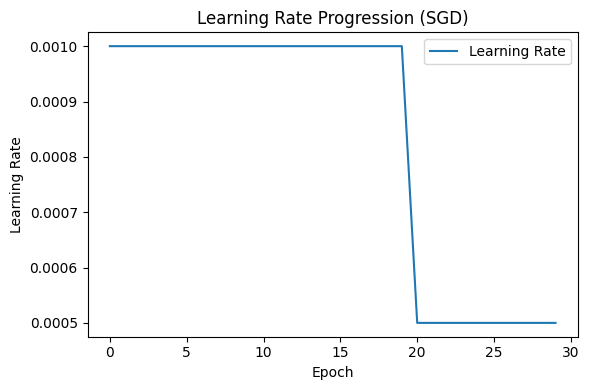

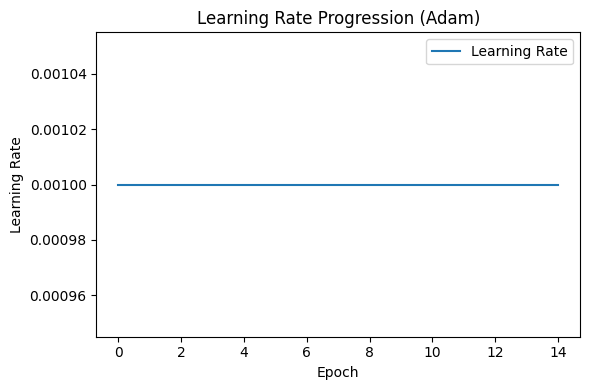

SGD Final Validation Loss: 1.0298, Final Validation Accuracy: 49.05%
Adam Final Validation Loss: 1.0372, Final Validation Accuracy: 49.05%


In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection
import warnings
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings('ignore')

# Load and preprocess data
train_home_team_statistics_df = pd.read_csv('data/Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('data/Train_Data/train_away_team_statistics_df.csv', index_col=0)
train_scores = pd.read_csv('data/Y_train_1rknArQ.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:, 2:]
train_away = train_away_team_statistics_df.iloc[:, 2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data = pd.concat([train_home, train_away], join='inner', axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf: np.nan, -np.inf: np.nan})
train_scores_indices = train_scores.idxmax(axis=1).map({'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2})

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    train_data, train_scores_indices, train_size=0.8, random_state=42
)

# Prepare data for PyTorch
X_train_tensor = torch.from_numpy(X_train.fillna(0).to_numpy()).float()
y_train_tensor = torch.from_numpy(y_train.to_numpy()).long()
X_valid_tensor = torch.from_numpy(X_valid.fillna(0).to_numpy()).float()
y_valid_tensor = torch.from_numpy(y_valid.to_numpy()).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define evaluation function
def evaluate(model, criterion, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss += criterion(outputs, labels).item()
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return total_loss / len(loader), accuracy

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return False
        return True

# Train the model
def train_model(optimizer_name, lr=0.001, weight_decay=1e-5, hidden_size=32, num_epochs=30, early_stopping_patience=10):
    input_size = X_train_tensor.shape[1]
    num_classes = len(np.unique(y_train))

    model = NeuralNet(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unknown optimizer")

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)

    train_losses, valid_losses, accuracies = [], [], []
    learning_rates = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        valid_loss, valid_accuracy = evaluate(model, criterion, valid_loader)
        valid_losses.append(valid_loss)
        accuracies.append(valid_accuracy)

        learning_rates.append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%, Learning Rate: {learning_rates[-1]:.6f}')

        if not early_stopping.step(valid_loss):
            break

        scheduler.step()

    return train_losses, valid_losses, accuracies, valid_loss, valid_accuracy, learning_rates

# Plot metrics
def plot_metrics(train_losses, valid_losses, accuracies, title_suffix=""):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Convergence {title_suffix}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Accuracy Convergence {title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot learning rate progression
def plot_learning_rate(learning_rates, title_suffix=""):
    plt.figure(figsize=(6, 4))
    plt.plot(learning_rates, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'Learning Rate Progression {title_suffix}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot comparison
def plot_comparison(sgd_results, adam_results):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(sgd_results[0], label='SGD Train Loss', linestyle='--')
    plt.plot(sgd_results[1], label='SGD Valid Loss')
    plt.plot(adam_results[0], label='Adam Train Loss', linestyle='--')
    plt.plot(adam_results[1], label='Adam Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Convergence Comparison')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(sgd_results[2], label='SGD Accuracy')
    plt.plot(adam_results[2], label='Adam Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Convergence Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train and evaluate models
sgd_results = train_model('SGD')
adam_results = train_model('Adam')

# Plot results
plot_comparison(sgd_results, adam_results)
plot_learning_rate(sgd_results[5], title_suffix="(SGD)")
plot_learning_rate(adam_results[5], title_suffix="(Adam)")

# Final performance
print(f"SGD Final Validation Loss: {sgd_results[3]:.4f}, Final Validation Accuracy: {sgd_results[4]:.2f}%")
print(f"Adam Final Validation Loss: {adam_results[3]:.4f}, Final Validation Accuracy: {adam_results[4]:.2f}%")
